# Problem Statement

Every artist goes through changes in life and their music usually reflects that. I'm a big fan of John Mayer's music, mostly because he's one of the few artists that are keeping the guitar solo alive in modern music. Being a big guitar fan I often get distracted and lost in the guitar solos and background music. But the music aspect aside I was curious to learn what John Mayer sings about through his lyrics and find out: 
1. Changes in vocablury across his albums
2. The general sentiment of his lyrics (did they have a positive tone or a negative tone)
3. What topics did he sing about

I've broken down this project into XX main steps

1. **Create the Data Sets**
    1. Get the raw data by scraping
    2. Clean the Data
    3. Convert the data into required formats (Corpus and Document-Term-Matrix)


2. **EDA (Explarotary Data Analysis)**
    1. Most common words
    2. Wordclouds

3. **Sentiment Analysis**

4. **Topic Modeling**

# Create the Data Sets

## Introduction

In this section I will perform three main steps:

1. Get the Data - This will involve scraping the lyrics of each song from a website
2. Clean the Data - This invovles pre-processing so that it fits the form on which we can do analysis and NLP on
3. Convert the cleaned data into a format that can be used by the algorithms

The output of this notebook will be clean, organized data in two standard text formats:

1. **Corpus** - a collection of text
2. **Document-Term Matrix** - word counts in matrix format

## 1. Getting the Raw Data

Getting the lyrics of the song involves two steps:

1. Make a list of all the songs that I need lyrics for
    - Organize the song name, album and year
2. Scrape a website to extract the lyrics for each song in the list
    - Use genius.com API as well as BeautifulSoup to scrape the lyrics

### Organize song names

For one of my other projects I wanted to get the names and artists for hundreds of songs across the decades. In that case I used **selenium** to scrape an online list of songs to get the song name and artist.
But in this case there are only a few albums and a simple google search gives me the names of the songs, the album and the year.

In [56]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

import pandas as pd
import csv

In [58]:
discography_df_raw = pd.read_csv('data_sets/JM_Discography.csv')

In [3]:
print(discography_df_raw.shape)
discography_df_raw.head(2)

(81, 5)


,Album,Year,Track #,Title,Track Length
0,Room For Squares,2001,1,No Such Thing,3:51
1,Room For Squares,2001,2,Why Georgia,4:29


In [4]:
# Convert Track length into seconds
import datetime
import time

def convert_to_seconds(track_len):
    #ftr = [3600,60,1]
    #return sum([a*b for a,b in zip(ftr, map(int,timestr.split(':')))])
    time_obj = time.strptime(track_len.split(',')[0],'%M:%S')
    return time_obj.tm_min*60+time_obj.tm_sec

convert_t = lambda x: convert_to_seconds(x)

In [5]:
#discography_clean['Lyrics'] = pd.DataFrame(discography_clean.Lyrics.apply(round2))
discography_df_raw['Track Length'] = pd.DataFrame(discography_df_raw['Track Length'].apply(convert_t))
discography_df_raw.head()

,Album,Year,Track #,Title,Track Length
0,Room For Squares,2001,1,No Such Thing,231
1,Room For Squares,2001,2,Why Georgia,269
2,Room For Squares,2001,3,My Stupid Mouth,225
3,Room For Squares,2001,4,Your Body Is A Wonderland,250
4,Room For Squares,2001,5,Neon,262


### Get lyrics from Genius.com using their API

In [101]:
#Get lyrics from Genius

# Make HTTP requests
import requests
# Scrape data from an HTML document
from bs4 import BeautifulSoup
# I/O
import os
# Search and manipulate strings
import re

import pickle

#Search for song and then scrape lyrics

GENIUS_API_TOKEN = "sMKu7QNqzkVUk4LQ-bJUPiwWXHyQpNJIntW4sW1xbt8AuyjAFY98sp4JOUV7TiwJ"
#eras = ['seventies','eighties', 'nineties', 'twothousands', 'twentytens']

# Get song object from Genuis API
def request_song_object(song_name):
    
    try:
        base_url = 'https://api.genius.com'
        headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    #   search_url = base_url + '/search?q='+song_name  # Or include data dictionary in request
        search_url = base_url + '/search?'
        data = {'q': song_name}
        response = requests.get(search_url, data=data, headers=headers)
        return response
    except:
        print("Couldn't get url for: "+song_name)
        return ''

def request_artist_info(artist_name, page):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_url = base_url + '/search?per_page=10&page=' + str(page)
    data = {'q': artist_name}
    response = requests.get(search_url, data=data, headers=headers)
    return response

def request_song_url(song_name):
    page = 1
    songs = []
    logger.info("getting url for: "+song_name)
    response = request_song_object(song_name)
    json = response.json()
    
    return json['response']['hits'][0]['result']['url']

# Scrape lyrics from a Genius.com song URL
def scrape_song_lyrics(url):
    
    try: 
        logger.info('Getting lyrics for: '+url)
        page = requests.get(url)
        html = BeautifulSoup(page.text, 'html.parser')
        lyrics = html.find('div', class_='lyrics').get_text()
        #remove identifiers like chorus, verse, etc
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)
        #remove empty lines
        lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
        #replace new line with ' '
        lyrics = lyrics.replace('\n',' ')
        return lyrics
    except:
        print("Failed to get lyrics for: "+url)
        return ''

def get_url_list(songList):

    #Does the below code in one line
    urlList = [request_song_url(songName) for songName in songList]
    
#     urlList = []
#     for songName in songList:
#         urlList.append(request_song_url(songName))
    return urlList

In [7]:
# Check if the lyrics seem right
url = request_song_url("Clarity John Mayer")
url

INFO:root:getting url for: Clarity John Mayer


'https://genius.com/John-mayer-clarity-lyrics'

In [8]:
lyrics = scrape_song_lyrics(url)
logger.debug(lyrics)

INFO:root:Getting lyrics for: https://genius.com/John-mayer-clarity-lyrics


In [9]:
# Use API to find lyrics page and scrape lyrics for each song using BeautifulSoup

# creating a blank series 
lyrics = pd.Series([]) 

for i,title in enumerate(discography_df_raw['Title']):
    song_url = request_song_url(title+" John Mayer")
    song_lyrics = scrape_song_lyrics(song_url)
    lyrics[i]=song_lyrics

<ipython-input-9-06f1cfeae1c7>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lyrics = pd.Series([])
INFO:root:getting url for: No Such Thing John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-no-such-thing-lyrics
INFO:root:getting url for: Why Georgia John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-why-georgia-lyrics
INFO:root:getting url for: My Stupid Mouth John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-my-stupid-mouth-lyrics
INFO:root:getting url for: Your Body Is A Wonderland John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-your-body-is-a-wonderland-lyrics
INFO:root:getting url for: Neon John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-neon-lyrics
INFO:root:getting url for: City Love John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-ma

Failed to get lyrics for: https://genius.com/John-mayer-queen-of-california-lyrics


INFO:root:Getting lyrics for: https://genius.com/John-mayer-the-age-of-worry-lyrics
INFO:root:getting url for: Shadow Days John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-shadow-days-lyrics
INFO:root:getting url for: Speak For Me John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-speak-for-me-lyrics
INFO:root:getting url for: Something Like Olivia John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-something-like-olivia-lyrics
INFO:root:getting url for: Born And Raised John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-born-and-raised-lyrics
INFO:root:getting url for: If I Ever Get Around To Living John Mayer


Failed to get lyrics for: https://genius.com/John-mayer-born-and-raised-lyrics


INFO:root:Getting lyrics for: https://genius.com/John-mayer-if-i-ever-get-around-to-living-lyrics
INFO:root:getting url for: Love Is A Verb John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-love-is-a-verb-lyrics
INFO:root:getting url for: Walt Grace's Submarine Test, January 1967 John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-walt-graces-submarine-test-january-1967-lyrics
INFO:root:getting url for: Whiskey\, Whiskey\, Whiskey John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-whiskey-whiskey-whiskey-lyrics
INFO:root:getting url for: A Face To Call Home John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-a-face-to-call-home-lyrics
INFO:root:getting url for: Born And Raised (Reprise) John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-born-and-raised-reprise-lyrics
INFO:root:getting url for: Wildfire John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-wildfire-lyrics


Failed to get lyrics for: https://genius.com/John-mayer-wildfire-lyrics


INFO:root:Getting lyrics for: https://genius.com/John-mayer-dear-marie-lyrics
INFO:root:getting url for: Waitin' On The Day John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-waitin-on-the-day-lyrics
INFO:root:getting url for: Paper Doll John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-paper-doll-lyrics
INFO:root:getting url for: Call Me The Breeze John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-call-me-the-breeze-lyrics
INFO:root:getting url for: Who You Love John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-who-you-love-lyrics
INFO:root:getting url for: I Will Be Found (Lost At Sea) John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-i-will-be-found-lost-at-sea-lyrics
INFO:root:getting url for: Wildfire John Mayer
INFO:root:Getting lyrics for: https://genius.com/John-mayer-wildfire-lyrics
INFO:root:getting url for: You're No One 'Til Someone Lets You Down John Mayer
INFO:root:Gett

In [10]:
discography_df_raw.insert(len(discography_df_raw.columns),'Lyrics',lyrics)

In [11]:
# See which songs we failed to get lyrics for
discography_df_raw.loc[discography_df_raw['Lyrics']=='']


,Album,Year,Track #,Title,Track Length,Lyrics
46,Born And Raised,2012,1,Queen Of California,249,
51,Born And Raised,2012,6,Born And Raised,289,
58,Paradise Valley,2013,1,Wildfire,255,
75,The Search For Everything,2017,7,"""Theme from ""The Search for Everything""""",114,


In [12]:
discography_df_raw.loc[discography_df_raw['Title'].str.contains('Edge Of')]['Lyrics'].item()

"Young and full of running Tell me where has that taken me Just a great figure eight or a tiny infinity Love is really nothing But a dream that keeps waking me For all of my trying, we still end up dying How can it be Don't say a word, just come over and lie here with me Because I'm just about to set fire to everything I see I want you so bad, I'll go back on the things I believe There I just said it, I'm scared you'll forget about me So young and full of running All the way to the edge of desire Steady my breathing, silently screaming I have to have you now Wired and I'm tired Think I'll sleep in my clothes on the floor Or maybe this mattress will spin on its axis And find me on yours Don't say a word, just come over and lie here with me Because I'm just about to set fire to everything I see I want you so bad, I'll go back on the things I believe There I just said it, I'm scared you'll forget about me"

## Cleaning the Data

For starters I did the following just to get the lyrics chunks in good shape to create a document term matrix

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**
* Stemming / lemmatization
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

In [13]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x) #Notebook

In [31]:
discography_df_raw.head()

,Album,Year,Track #,Title,Track Length,Lyrics
0,Room For Squares,2001,1,No Such Thing,231,"""Welcome to the real world"", she said to me Co..."
1,Room For Squares,2001,2,Why Georgia,269,I am driving up '85 in the Kind of morning tha...
2,Room For Squares,2001,3,My Stupid Mouth,225,My stupid mouth Has got me in trouble I said t...
3,Room For Squares,2001,4,Your Body Is A Wonderland,250,We got the afternoon You got this room for two...
4,Room For Squares,2001,5,Neon,262,When sky blue gets dark enough To see the colo...


In [32]:
discography_clean = discography_df_raw.copy()

# Let's take a look at the updated text
discography_clean['Lyrics'] = pd.DataFrame(discography_df_raw.Lyrics.apply(round1))
discography_clean.head() 

,Album,Year,Track #,Title,Track Length,Lyrics
0,Room For Squares,2001,1,No Such Thing,231,welcome to the real world she said to me conde...
1,Room For Squares,2001,2,Why Georgia,269,i am driving up in the kind of morning that l...
2,Room For Squares,2001,3,My Stupid Mouth,225,my stupid mouth has got me in trouble i said t...
3,Room For Squares,2001,4,Your Body Is A Wonderland,250,we got the afternoon you got this room for two...
4,Room For Squares,2001,5,Neon,262,when sky blue gets dark enough to see the colo...


In [33]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [55]:
discography_clean['Lyrics'] = pd.DataFrame(discography_clean.Lyrics.apply(round2))

# Change index
discography_clean.set_index("Title", inplace = True, append = False, drop = False)
discography_clean

discography_clean.head(20)

,Album,Year,Track #,Title,Track Length,Lyrics
Title,,,,,,
No Such Thing,Room For Squares,2001,1,No Such Thing,231,welcome to the real world she said to me conde...
Why Georgia,Room For Squares,2001,2,Why Georgia,269,i am driving up in the kind of morning that l...
My Stupid Mouth,Room For Squares,2001,3,My Stupid Mouth,225,my stupid mouth has got me in trouble i said t...
Your Body Is A Wonderland,Room For Squares,2001,4,Your Body Is A Wonderland,250,we got the afternoon you got this room for two...
Neon,Room For Squares,2001,5,Neon,262,when sky blue gets dark enough to see the colo...
City Love,Room For Squares,2001,6,City Love,240,i never liked this apple much it always seemed...
83,Room For Squares,2001,7,83,291,ive these dreams im walking home home when it ...
3X5,Room For Squares,2001,8,3X5,290,im writing you to catch you up on places ive b...
Love Song For No One,Room For Squares,2001,9,Love Song For No One,202,staying home alone on a friday flat on the flo...


**NOTE:** Other cleaning and pre-processing steps I would consider are:
* Mark 'cheering' and 'cheer' as the same word (stemming / lemmatization)
* Combine 'thank you' into one term (bi-grams)
* And a lot more...

## Organizing the Data

As mentioned earlier, we want to get the data organized into the following two formats:
1. **Corpus -** a collection of text
2. **Document-Term Matrix -** word counts in matrix format

I will aggregate the data in two levels

1. Document Term Matrix per song
2. **Document Term Matrix per album** (Group all the lyrics in each album together). This is the more useflu one since we are tryiing to observe the changes over time. Grouping by album is the same as grouping by year


### Corpus

The corpus has already been created in the previous section - The corpus of each song is held in discography_clean['Lyrics']

In [42]:
# Let's pickle it for later use
discography_df_raw.to_pickle("lyrics/corpus_original.pkl")
discography_clean.to_pickle("lyrics/corpus.pkl")

#### Aggregate by Album

In [43]:
#Inner join to get the resulting corpus

tmp_df = discography_clean.groupby(['Album','Year'])['Track Length'].sum().reset_index()
print(tmp_df.shape)

tmp_df2 = discography_clean.groupby(['Album','Year'])['Track #'].count().reset_index()
print(tmp_df2.shape)

# Merge the two tables
album_df = tmp_df.merge(tmp_df2, on=['Album', 'Year'], how='inner')

tmp_df3 = discography_clean.groupby(['Album','Year'])['Lyrics'].agg(lambda x: ' '.join(x)).reset_index()
print(tmp_df3.shape)

album_df = album_df.merge(tmp_df3, on=['Album', 'Year'], how='inner').sort_values(by='Year')

# Rename
album_df = album_df.rename(columns={"Track Length": "Total Album Length", "Track #": "Num_of_Tracks"})

# Change index
album_df.set_index("Year", inplace = True, append = False, drop = False)
album_df

(7, 3)
(7, 3)
(7, 3)


,Album,Year,Total Album Length,Num_of_Tracks,Lyrics
Year,,,,,
2001,Room For Squares,2001,3259,13,welcome to the real world she said to me conde...
2003,Heavier Things,2003,2780,10,i worry i weigh three times my body i worry i ...
2006,Continuum,2006,2987,12,me and all my friends were all misunderstood t...
2009,Battle Studies,2009,2798,11,lightning strikes inside my chest to keep me u...
2012,Born And Raised,2012,2799,12,ooh ooh ooh ooh close your eyes and clone you...
2013,Paradise Valley,2013,2410,11,dear marie tell me what it was i used to be d...
2017,The Search For Everything,2017,2629,12,i still feel like your man i still feel like y...


In [44]:
# Let's pickle it for later use
album_df.to_pickle("lyrics/album_corpus.pkl")

### Document-Term Matrix

Document-Term matrix converts the the text into tokens, which means breaking it down into smaller parts. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.

In [45]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
song_cv = cv.fit_transform(discography_clean.Lyrics)
song_dtm = pd.DataFrame(song_cv.toarray(), columns=cv.get_feature_names())
song_dtm.index = discography_clean.index
song_dtm

,accepted,act,actors,address,adore,advice,affair,afternoon,age,ago,...,yellow,yes,yesterday,york,youd,youll,young,younger,youre,youve
Title,,,,,,,,,,,,,,,,,,,,,
No Such Thing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
Why Georgia,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
My Stupid Mouth,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Your Body Is A Wonderland,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Neon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"""Moving On and Getting Over""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
"""Never on the Day You Leave""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
"""Rosie""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Document Term Matrix for Albums

In [46]:
cv_a = CountVectorizer(stop_words='english')
album_cv = cv_a.fit_transform(album_df.Lyrics)
album_dtm = pd.DataFrame(album_cv.toarray(), columns=cv_a.get_feature_names())
album_dtm.index = album_df.index
album_dtm

,accepted,act,actors,address,adore,advice,affair,afternoon,age,ago,...,yellow,yes,yesterday,york,youd,youll,young,younger,youre,youve
Year,,,,,,,,,,,,,,,,,,,,,
2001,0,0,1,0,0,0,0,2,0,1,...,0,0,1,0,0,4,0,0,4,3
2003,0,0,0,1,1,0,0,2,0,0,...,0,3,0,0,1,2,0,0,4,0
2006,0,0,0,0,0,3,0,0,0,0,...,1,0,0,0,0,2,2,0,8,0
2009,0,0,0,0,0,0,1,0,0,0,...,1,1,1,3,0,2,2,1,2,0
2012,1,1,0,0,0,0,0,0,10,0,...,0,0,1,1,1,0,0,0,6,4
2013,0,0,0,0,1,0,0,0,1,0,...,0,2,0,0,2,5,0,0,16,3
2017,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,2,0,5,4


In [47]:
# Pickle the Document-term matrix
song_dtm.to_pickle("lyrics/song_dtm.pkl")
album_dtm.to_pickle("lyrics/album_dtm.pkl")

# Pickle the cv
pickle.dump(cv, open("lyrics/cv.pkl", "wb"))
pickle.dump(cv_a, open("lyrics/cv_a.pkl", "wb"))

# Exploratory Data Analysis

Before moving into more complex data analysis, I wanted to see if the data I have right now makes sense, and check for any observations that are out of the ordinary or might require further cleaning. I'm going to look for the more straight forward patterns using EDA before identifying the hidden patterns with ML/NLP techniques. For each era, I will look at:

1. Most common words - find these and create word clouds
2. Size of the vocablury

### Most Common Words

In [129]:
song_dtm = pd.read_pickle('lyrics/song_dtm.pkl')
album_dtm = pd.read_pickle('lyrics/album_dtm.pkl')

In [130]:
song_dtm = song_dtm.transpose()
song_dtm.head()

Title,No Such Thing,Why Georgia,My Stupid Mouth,Your Body Is A Wonderland,Neon,City Love,83,3X5,Love Song For No One,Back To You,...,"""Helpless""","""Love on the Weekend""","""In the Blood""","""Changing""","""Theme from ""The Search for Everything""""","""Moving On and Getting Over""","""Never on the Day You Leave""","""Rosie""","""Roll It on Home""","""You're Gonna Live Forever in Me"""
accepted,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
act,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actors,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
address,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
album_dtm = album_dtm.transpose()
album_dtm.head()

Year,2001,2003,2006,2009,2012,2013,2017
accepted,0,0,0,0,1,0,0
act,0,0,0,0,1,0,0
actors,1,0,0,0,0,0,0
address,0,1,0,0,0,0,0
adore,0,1,0,0,0,1,0


In [132]:
# Top 30 words in each album/song
def get_top_n_words_dict(data_dtm):

    top_dict = {}

    for album in data_dtm.columns:
        top = data_dtm[album].sort_values(ascending=False).head(30)
        top_dict[album]= list(zip(top.index, top.values))

    return top_dict

top_dict = get_top_n_words_dict(album_dtm)
top_dict

{2001: [('just', 29),
  ('im', 29),
  ('like', 22),
  ('want', 17),
  ('comes', 15),
  ('way', 13),
  ('love', 13),
  ('ill', 13),
  ('got', 13),
  ('life', 13),
  ('oh', 12),
  ('neon', 12),
  ('tell', 11),
  ('away', 10),
  ('long', 10),
  ('world', 10),
  ('right', 10),
  ('body', 10),
  ('goes', 9),
  ('living', 9),
  ('said', 9),
  ('time', 9),
  ('speaking', 8),
  ('tired', 8),
  ('ive', 8),
  ('hurry', 8),
  ('make', 7),
  ('hands', 7),
  ('good', 7),
  ('wonderland', 7)],
 2003: [('im', 30),
  ('dont', 25),
  ('ill', 23),
  ('love', 23),
  ('life', 20),
  ('know', 20),
  ('home', 19),
  ('come', 18),
  ('got', 17),
  ('just', 15),
  ('right', 15),
  ('heart', 15),
  ('sadness', 14),
  ('cause', 14),
  ('bed', 12),
  ('time', 12),
  ('daughters', 11),
  ('good', 11),
  ('wont', 11),
  ('oooooo', 10),
  ('going', 9),
  ('want', 9),
  ('someday', 9),
  ('mothers', 9),
  ('oh', 8),
  ('yeah', 8),
  ('wait', 8),
  ('like', 8),
  ('baby', 7),
  ('think', 7)],
 2006: [('im', 38),
  ('

In [133]:
# Print the top 15 words said in each album
for album, top_words in top_dict.items():
    print(album)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

2001
just, im, like, want, comes, way, love, ill, got, life, oh, neon, tell, away
---
2003
im, dont, ill, love, life, know, home, come, got, just, right, heart, sadness, cause
---
2006
im, dont, going, waiting, world, know, love, gone, oh, ooh, change, bold, hold, stop
---
2009
im, say, half, heart, dont, want, goodbye, love, way, know, thats, time, got, heartbreak
---
2012
im, whiskey, home, love, like, got, time, water, olivia, aint, face, going, worry, right
---
2013
love, im, little, youre, got, just, ive, time, know, way, day, dont, home, waiting
---
2017
im, like, feel, love, man, just, tell, changing, gonna, oh, home, leave, moving, roll
---


**NOTE:** it seems that some of the top words don't really add any depth to our analysis nor meaning. I'm going to remove these by adding them to our stop words list

In [134]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each era and aggregate them 
def get_common_words_in_dict(top_dict):
    words = []
    for album in top_dict.keys():
        top = [word for (word, count) in top_dict[album]]
        for t in top:
            words.append(t)
    return words

words = get_common_words_in_dict(top_dict)
len(words)

210

In [135]:
# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('just', 7),
 ('im', 7),
 ('love', 7),
 ('like', 6),
 ('time', 6),
 ('know', 6),
 ('got', 5),
 ('oh', 5),
 ('dont', 5),
 ('heart', 5),
 ('want', 4),
 ('ill', 4),
 ('life', 4),
 ('long', 4),
 ('good', 4),
 ('home', 4),
 ('come', 4),
 ('way', 3),
 ('tell', 3),
 ('right', 3),
 ('going', 3),
 ('away', 2),
 ('world', 2),
 ('ive', 2),
 ('make', 2),
 ('cause', 2),
 ('baby', 2),
 ('think', 2),
 ('waiting', 2),
 ('hold', 2),
 ('youre', 2),
 ('say', 2),
 ('run', 2),
 ('remember', 2),
 ('man', 2),
 ('day', 2),
 ('comes', 1),
 ('neon', 1),
 ('body', 1),
 ('goes', 1),
 ('living', 1),
 ('said', 1),
 ('speaking', 1),
 ('tired', 1),
 ('hurry', 1),
 ('hands', 1),
 ('wonderland', 1),
 ('sadness', 1),
 ('bed', 1),
 ('daughters', 1),
 ('wont', 1),
 ('oooooo', 1),
 ('someday', 1),
 ('mothers', 1),
 ('yeah', 1),
 ('wait', 1),
 ('gone', 1),
 ('ooh', 1),
 ('change', 1),
 ('bold', 1),
 ('stop', 1),
 ('repair', 1),
 ('belief', 1),
 ('trust', 1),
 ('room', 1),
 ('lovin', 1),
 ('train', 1),
 ('testing', 1),
 ('h

Here I wanted to see which words are present in all albums as top words. If all of the albums have it as a top word, might not add much value and can possibly exclude it from the list. This is kind of similar to TD-IDF. Right now I will leave them as they may get taken care of by stop words removal

In [136]:
# If all of the albums have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 5]
add_stop_words

['just', 'im', 'love', 'like', 'time', 'know', 'got', 'oh', 'dont', 'heart']

In [137]:
keep_words = ['love','time','heart','dont']
add_stop_words = [ele for ele in add_stop_words if ele not in keep_words] #Notebook
add_stop_words

['just', 'im', 'like', 'know', 'got', 'oh']

In [138]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('lyrics/album_corpus.pkl')
#print(data_clean.head())

# Add new stop words - includes the words identified in all documents and nltk stop words, and scikit learn stop words

from nltk.corpus import stopwords
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words).union(stopwords.words('english'))
#stop_words = text.ENGLISH_STOP_WORDS.union(stopwords.words('english'))

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.Lyrics)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
import pickle
pickle.dump(cv, open("lyrics/cv_a_stop.pkl", "wb"))
data_stop.to_pickle("lyrics/album_dtm_stop.pkl")

In [139]:
data_stop

,accepted,act,actors,address,adore,advice,affair,afternoon,age,ago,...,yellow,yes,yesterday,york,youd,youll,young,younger,youre,youve
Year,,,,,,,,,,,,,,,,,,,,,
2001,0,0,1,0,0,0,0,2,0,1,...,0,0,1,0,0,4,0,0,4,3
2003,0,0,0,1,1,0,0,2,0,0,...,0,3,0,0,1,2,0,0,4,0
2006,0,0,0,0,0,3,0,0,0,0,...,1,0,0,0,0,2,2,0,8,0
2009,0,0,0,0,0,0,1,0,0,0,...,1,1,1,3,0,2,2,1,2,0
2012,1,1,0,0,0,0,0,0,10,0,...,0,0,1,1,1,0,0,0,6,4
2013,0,0,0,0,1,0,0,0,1,0,...,0,2,0,0,2,5,0,0,16,3
2017,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,2,2,0,5,4


Do the same cleaning and removal of stop words for the song lyrics dataframe

In [140]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('lyrics/corpus.pkl')
print(data_clean.head())

# Add new stop words - includes the words identified in all documents and nltk stop words, and scikit learn stop words

from nltk.corpus import stopwords
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words).union(stopwords.words('english'))
#stop_words = text.ENGLISH_STOP_WORDS.union(stopwords.words('english'))

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.Lyrics)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
import pickle
pickle.dump(cv, open("lyrics/cv_s_stop.pkl", "wb"))
data_stop.to_pickle("lyrics/song_dtm_stop.pkl")

                                      Album  Year  Track #  \
Title                                                        
No Such Thing              Room For Squares  2001        1   
Why Georgia                Room For Squares  2001        2   
My Stupid Mouth            Room For Squares  2001        3   
Your Body Is A Wonderland  Room For Squares  2001        4   
Neon                       Room For Squares  2001        5   

                                               Title  Track Length  \
Title                                                                
No Such Thing                          No Such Thing           231   
Why Georgia                              Why Georgia           269   
My Stupid Mouth                      My Stupid Mouth           225   
Your Body Is A Wonderland  Your Body Is A Wonderland           250   
Neon                                            Neon           262   

                                                                      Lyri

#### TODO: Update corpus with stop words removed list

### Word Clouds

In [141]:
# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

# The stop words from before are excluded from the word cloud
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [142]:
album_dtm.columns.values

array([2001, 2003, 2006, 2009, 2012, 2013, 2017])

In [143]:
album_clean

,Album,Year,Total Album Length,Num_of_Tracks,Lyrics
Year,,,,,
2001,Room For Squares,2001,3259,13,welcome to the real world she said to me conde...
2003,Heavier Things,2003,2780,10,i worry i weigh three times my body i worry i ...
2006,Continuum,2006,2987,12,me and all my friends were all misunderstood t...
2009,Battle Studies,2009,2798,11,lightning strikes inside my chest to keep me u...
2012,Born And Raised,2012,2799,12,ooh ooh ooh ooh close your eyes and clone you...
2013,Paradise Valley,2013,2410,11,dear marie tell me what it was i used to be d...
2017,The Search For Everything,2017,2629,12,i still feel like your man i still feel like y...


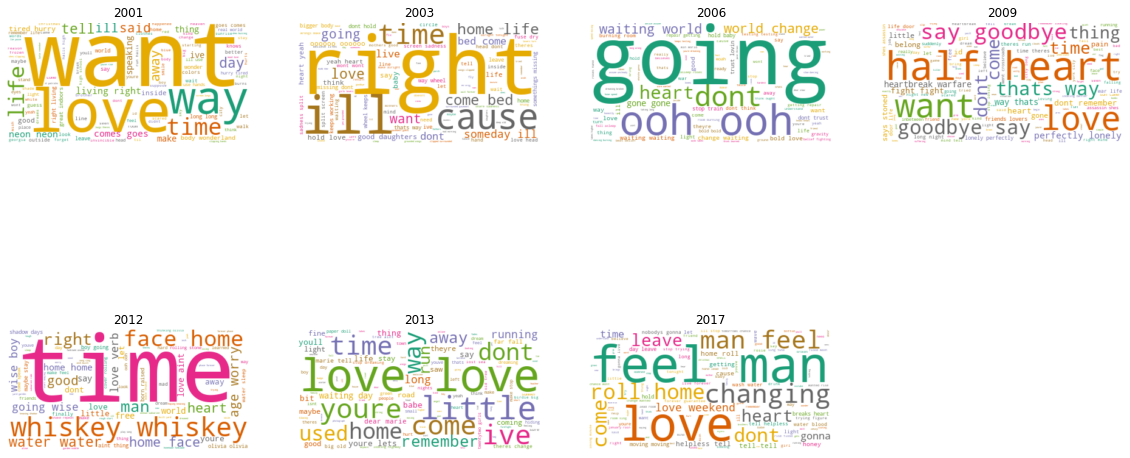

In [144]:
#album_clean = pd.read_pickle('lyrics/album_corpus.pkl')

# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 16]

# Create subplots for each album
for index, album in enumerate(album_dtm.columns.values):
    wc.generate(album_clean.Lyrics[album])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(album)
    
plt.show()

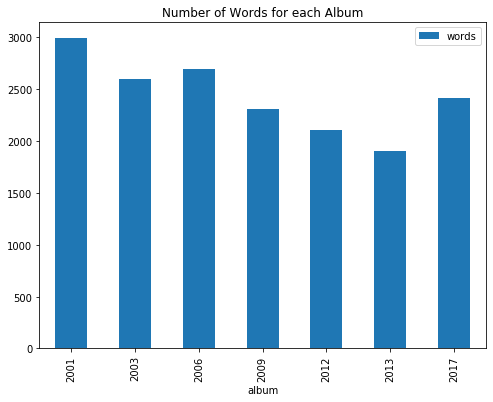

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

df_all_words = pd.DataFrame(columns=('album', 'words'))
i=0

#data_clean = pd.read_pickle('lyrics/corpus.pkl')
for i, album in enumerate(album_dtm.columns.values):
    num_of_words = 0
    num_of_words = len(album_clean.loc[album]['Lyrics'].split(" "))
    df_all_words.loc[i]=(album, num_of_words)

df_all_words.plot.bar(x='album', y='words', title='Number of Words for each Album');
plt.show()

The number of words don't tell us much. It would be more interesting to see richness in the vocablury of between the albums. The number of unique words divided by the total number of words would give this. Stop words have to be removed

In [149]:
df_all_words

,album,words
0,2001,2995
1,2003,2601
2,2006,2692
3,2009,2313
4,2012,2103
5,2013,1908
6,2017,2412


In [152]:
df_all_words[df_all_words['album']==2001]['words'].item()

2995

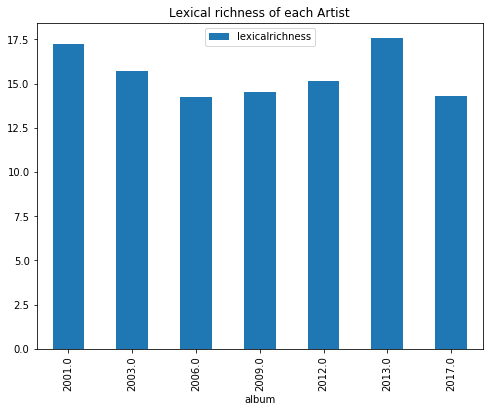

In [161]:
# Load the cleaned document term matrix (dtm) from which we have already removed stop words 
data_stop = pd.read_pickle("lyrics/album_dtm_stop.pkl")
data_stop_tmp = data_stop.transpose()

df_unique_words = pd.DataFrame(columns=('album', 'total_words','unique_words','lexicalrichness'))
for i, album in enumerate(album_dtm.columns.values):
    
    word_cnt = df_all_words[df_all_words['album']==album]['words'].item()
    
    unique_word_cnt = data_stop_tmp[data_stop_tmp[album]>=1][album].count()
    df_unique_words.loc[i] = (album, word_cnt, unique_word_cnt, (unique_word_cnt/float(word_cnt))*100)
    
df_unique_words.plot.bar(x='album', y='lexicalrichness', title='Lexical richness of each Artist');
plt.show()    

In [162]:
df_unique_words

,album,total_words,unique_words,lexicalrichness
0,2001.0,2995.0,517.0,17.262104
1,2003.0,2601.0,408.0,15.686275
2,2006.0,2692.0,384.0,14.264487
3,2009.0,2313.0,336.0,14.526589
4,2012.0,2103.0,319.0,15.168806
5,2013.0,1908.0,335.0,17.557652
6,2017.0,2412.0,345.0,14.303483
